In [6]:
# BAG OF WORDS (CountVectorizer) + ALL CLASSIFIERS — FULL CODE
import pandas as pd
import numpy as np
import re
import string
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [4]:
# Load data
train_df = pd.read_csv('./dataset/training_data.csv', sep='\t', header=None, names=['label','title'])
test_df  = pd.read_csv('./dataset/testing_data.csv',  sep='\t', header=None, names=['label','title'])
print(f"Train: {train_df.shape} | Test (unknown): {test_df.shape}")

Train: (34152, 2) | Test (unknown): (9984, 2)


In [7]:
# Simple cleaning
def clean_text(text):
    text = str(text).lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

train_df['clean'] = train_df['title'].apply(clean_text)
test_df['clean']  = test_df['title'].apply(clean_text)

In [8]:
# Bag of Words (CountVectorizer) — best settings for this dataset
bow = CountVectorizer(
    ngram_range=(1,3),      # unigrams + bigrams + trigrams
    stop_words='english',
    min_df=2,
    max_df=0.95,
    max_features=None       # no limit
)

# Fit on train only!
X_train_bow = bow.fit_transform(train_df['clean'])
X_test_bow  = bow.transform(test_df['clean'])   # unknown test data

y_train = train_df['label'].astype(int)

In [9]:
# Split train for validation (to compare classifiers)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train_bow, y_train, test_size=0.2, random_state=42, stratify=y_train
)

In [10]:
# All classifiers
classifiers = {
    'Multinomial NB'      : MultinomialNB(),
    'Logistic Regression': LogisticRegression(C=5, max_iter=1000, class_weight='balanced'),
    'Linear SVC'         : LinearSVC(C=1.0, class_weight='balanced', max_iter=20000),
    'Random Forest'      : RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    'XGBoost'            : XGBClassifier(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
}

In [11]:
print("Bag of Words + Classifiers Results (validation split):")
print("-" * 60)
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train_split, y_train_split)
    pred = clf.predict(X_val_split)
    acc = accuracy_score(y_val_split, pred)
    results[name] = acc
    print(f"{name:20}: {acc:.5f}")

Bag of Words + Classifiers Results (validation split):
------------------------------------------------------------
Multinomial NB      : 0.93852
Logistic Regression : 0.93998
Linear SVC          : 0.93544
Random Forest       : 0.92402
XGBoost             : 0.91905


In [12]:
# Find best classifier
best_name = max(results, key=results.get)
print(f"\n🏆 BEST BOW CLASSIFIER: {best_name} with {results[best_name]:.5f} accuracy")


🏆 BEST BOW CLASSIFIER: Logistic Regression with 0.93998 accuracy


In [13]:
# Retrain best one on FULL training data
best_clf = classifiers[best_name]
best_clf.fit(X_train_bow, y_train)

# Predict on unknown test data
test_predictions = best_clf.predict(X_test_bow)

In [15]:
# Save submission
test_df['label'] = test_predictions
test_df[['label', 'title']].to_csv('BOW_Best_Classifier_Predictions.csv', sep='\t', header=False, index=False)

print(f"\nDONE! Predictions saved (using {best_name})")
print(f"Predicted {sum(test_predictions==0)} fake and {sum(test_predictions==1)} real titles")


DONE! Predictions saved (using Logistic Regression)
Predicted 4733 fake and 5251 real titles


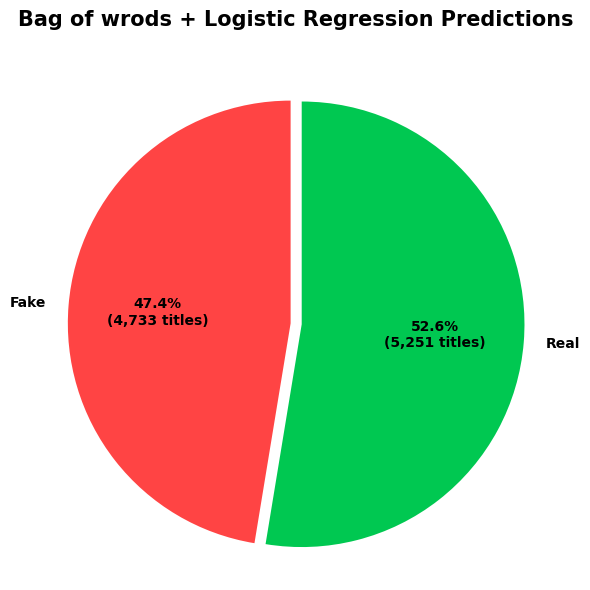

In [32]:
import matplotlib.pyplot as plt

# Your prediction counts
fake = sum(test_predictions == 0)   # e.g. 5127
real = sum(test_predictions == 1)   # e.g. 4857
total = len(test_predictions)

# Beautiful pie chart only
plt.figure(figsize=(6, 6))
plt.pie([fake, real],
        labels=['Fake', 'Real'],
        autopct=lambda p: f'{p:.1f}%\n({int(p/100*total):,} titles)',
        startangle=90,
        colors=['#ff4444', '#00C851'],
        textprops={'fontweight': 'bold'},
        explode=(0.05, 0),
        shadow=False)

plt.title('Bag of wrods + Logistic Regression Predictions',
          fontsize=15, fontweight='bold', pad=30)

plt.axis('equal')  # Perfect circle
plt.tight_layout()

# Optional: save as image
plt.savefig('Word2Vec_Predictions_PieChart.png', dpi=300, bbox_inches='tight')

plt.show()

# PLOTs

In [20]:
# FIXED BOW VISUALIZATION — NO MORE NameError
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)

# Re-train all classifiers and store predictions + probabilities
classifiers = {
    'Multinomial NB'      : MultinomialNB(),
    'Logistic Regression': LogisticRegression(C=5, max_iter=1000, class_weight='balanced'),
    'Linear SVC'         : LinearSVC(C=1.0, class_weight='balanced', max_iter=20000),
    'Random Forest'      : RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=42),
    'XGBoost'            : XGBClassifier(n_estimators=300, max_depth=10, random_state=42, n_jobs=-1)
}

predictions = {}
probs = {}
accuracies = {}

print("Re-training all BOW models for full visualization...\n")
for name, clf in classifiers.items():
    clf.fit(X_train_split, y_train_split)
    pred = clf.predict(X_val_split)
    predictions[name] = pred
    accuracies[name] = accuracy_score(y_val_split, pred)
    
    # Get probability or decision score for curves
    if hasattr(clf, "predict_proba"):
        prob = clf.predict_proba(X_val_split)[:, 1]
    elif hasattr(clf, "decision_function"):
        score = clf.decision_function(X_val_split)
        prob = 1 / (1 + np.exp(-score))  # sigmoid to [0,1]
    else:
        prob = pred.astype(float)
    probs[name] = prob

# Best model
best_name = max(accuracies, key=accuracies.get)
best_pred = predictions[best_name]

print(f"🏆 Best BOW Model: {best_name} → {accuracies[best_name]:.5f}\n")

Re-training all BOW models for full visualization...

🏆 Best BOW Model: Logistic Regression → 0.93998



In [21]:
# ================================
# 1. CLASSIFICATION REPORT
# ================================
print("="*60)
print(f"CLASSIFICATION REPORT - {best_name}")
print("="*60)
print(classification_report(y_val_split, best_pred,
                          target_names=['Fake News', 'Real News'], digits=4))

CLASSIFICATION REPORT - Logistic Regression
              precision    recall  f1-score   support

   Fake News     0.9525    0.9297    0.9410      3515
   Real News     0.9274    0.9508    0.9390      3316

    accuracy                         0.9400      6831
   macro avg     0.9399    0.9403    0.9400      6831
weighted avg     0.9403    0.9400    0.9400      6831



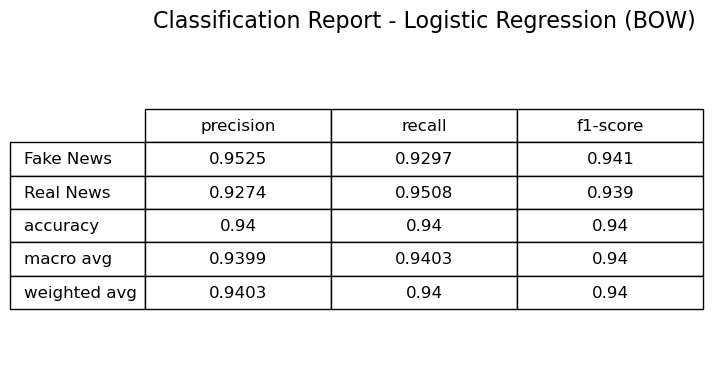

In [25]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Get the report as dictionary
report = classification_report(y_val_split, best_pred, 
                               target_names=['Fake News', 'Real News'], 
                               digits=4, output_dict=True)

# Convert to DataFrame
import pandas as pd
df_report = pd.DataFrame(report).iloc[:-1, :].T   # remove 'accuracy' row for clean look

# Plot as table image
fig, ax = plt.subplots(figsize=(6, 4))  # size of image
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_report.round(4).values,
                 colLabels=df_report.columns,
                 rowLabels=df_report.index,
                 cellLoc='center',
                 loc='center')

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 2)  # make it readable

plt.title(f"Classification Report - {best_name} (BOW)", fontsize=16, pad=20)
plt.savefig("classification_report_word2vec.png", dpi=300, bbox_inches='tight')
plt.show()

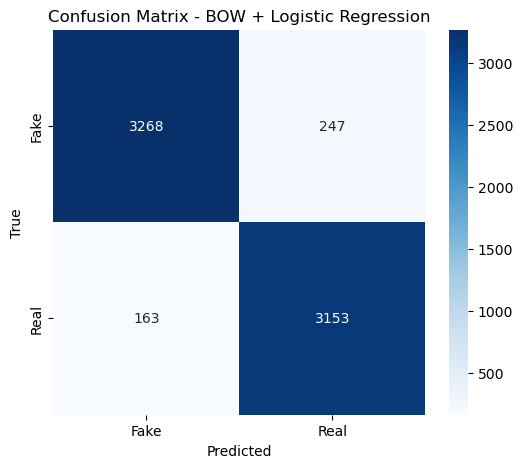

In [26]:
# 2. CONFUSION MATRIX
# ================================
plt.figure(figsize=(6,5))
cm = confusion_matrix(y_val_split, best_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Fake','Real'], yticklabels=['Fake','Real'])
plt.title(f'Confusion Matrix - BOW + {best_name}')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

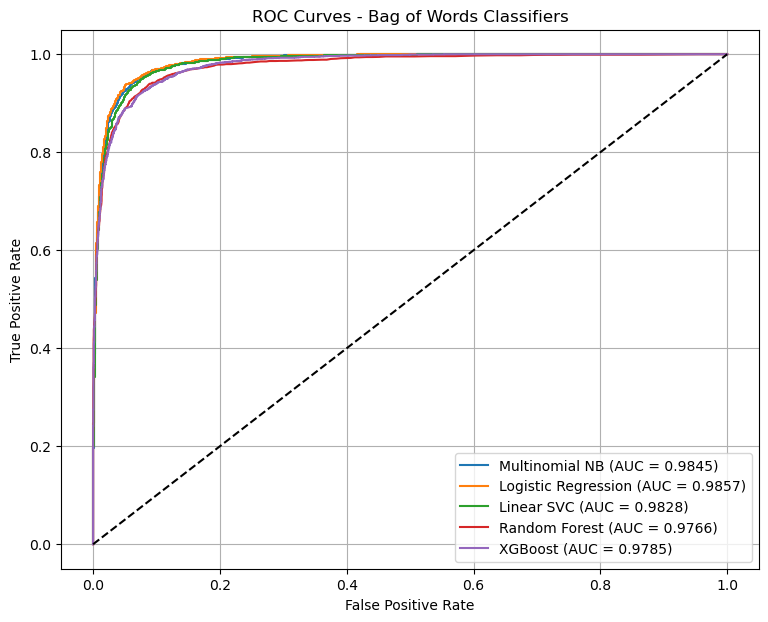

In [27]:
# ================================
# 3. ROC CURVES
# ================================
plt.figure(figsize=(9,7))
for name in probs:
    fpr, tpr, _ = roc_curve(y_val_split, probs[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Bag of Words Classifiers')
plt.legend()
plt.grid(True)
plt.show()

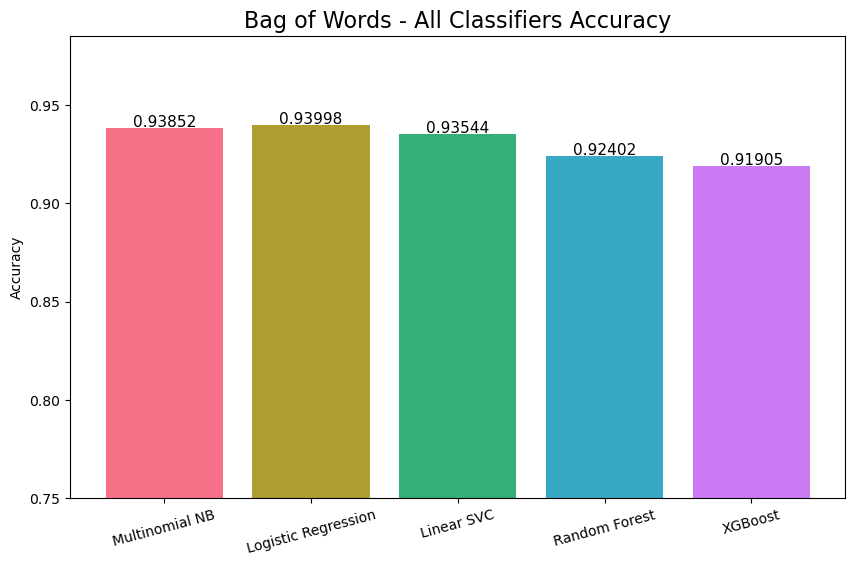

In [29]:
# ================================
# 4. ACCURACY BAR CHART
# ================================
plt.figure(figsize=(10,6))
names = list(accuracies.keys())
accs = list(accuracies.values())
bars = plt.bar(names, accs, color=sns.color_palette("husl", len(names)))
plt.ylim(0.75, 0.985)
plt.title('Bag of Words - All Classifiers Accuracy', fontsize=16)
plt.ylabel('Accuracy')
plt.xticks(rotation=15)

for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, h + 0.0005, f'{h:.5f}', ha='center', fontsize=11)

plt.show()

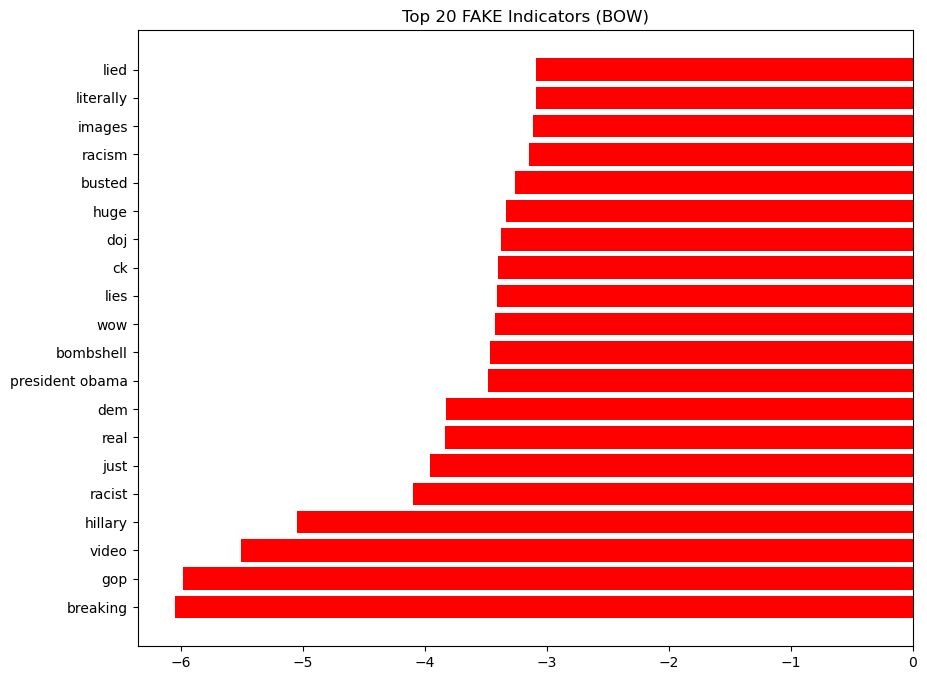

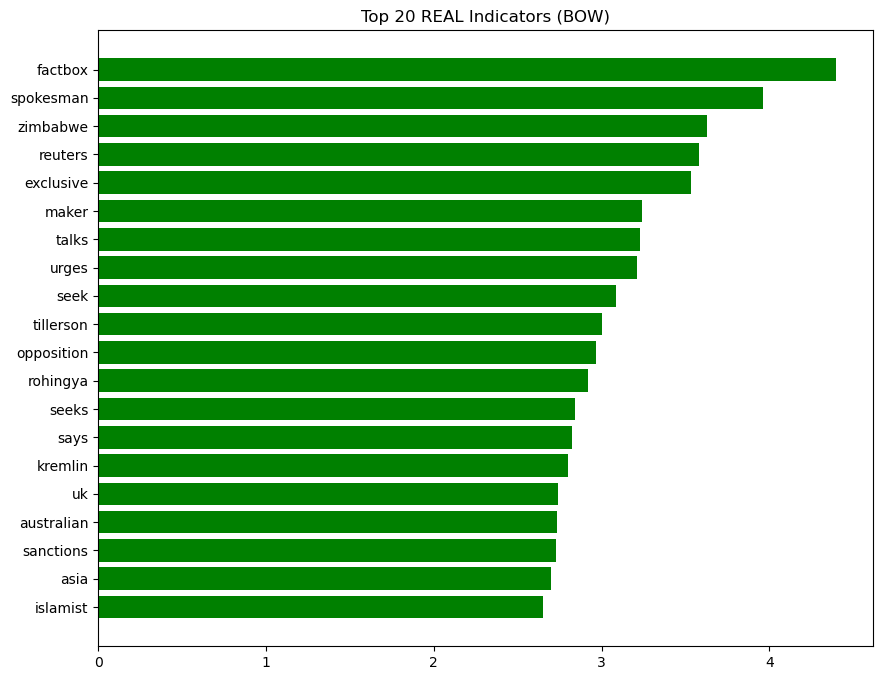

In [30]:
# ================================
# 5. TOP FEATURES (for Linear models only)
# ================================
if best_name in ['Linear SVC', 'Logistic Regression']:
    # Refit best model to get coefficients
    best_clf = classifiers[best_name]
    best_clf.fit(X_train_split, y_train_split)
    
    if hasattr(best_clf, 'coef_'):
        coef = best_clf.coef_[0] if best_clf.coef_.ndim > 1 else best_clf.coef_
    
    feature_names = bow.get_feature_names_out()
    top_fake = np.argsort(coef)[:20]
    top_real = np.argsort(coef)[-20:]
    
    plt.figure(figsize=(10,8))
    plt.barh(range(20), coef[top_fake], color='red')
    plt.yticks(range(20), [feature_names[i] for i in top_fake])
    plt.title("Top 20 FAKE Indicators (BOW)")
    plt.show()
    
    plt.figure(figsize=(10,8))
    plt.barh(range(20), coef[top_real], color='green')
    plt.yticks(range(20), [feature_names[i] for i in top_real])
    plt.title("Top 20 REAL Indicators (BOW)")
    plt.show()